In [3]:
import sys
!{sys.executable} -m pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [105]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from time import perf_counter

In [5]:
# configuring figure/plot params
custom_params = {'figure.figsize':(16, 9)} 
sns.set_theme(style="whitegrid", font_scale=1.3, rc=custom_params)

In [6]:
# loading dataset (it's a bit slow)
mnist_data = pd.read_csv('mnist.csv').values

In [7]:
labels = mnist_data[:, 0]  # 0 to 9
digits = mnist_data[:, 1:] # 42000 digits
print(labels, len(labels))
print(digits, len(digits[0]))
mnist_df = pd.DataFrame(mnist_data)
mnist_df.head()
# first column is label, all (784) other columns are pixel values (0-255)

[1 0 1 ... 7 6 9] 42000
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 784


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Exploration / Pre-Processing
Exploring data and plotting cool stuff

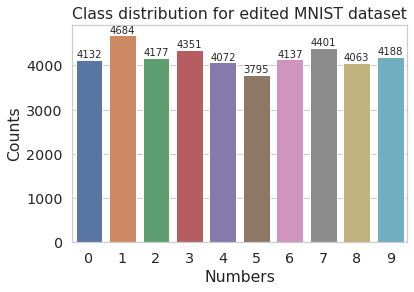

In [8]:
unique, counts = np.unique(labels, return_counts=True)
ax = sns.barplot(x=unique,y=counts)
ax.bar_label(ax.containers[0])
plt.title("Class distribution for edited MNIST dataset")
plt.ylabel("Counts")
plt.xlabel("Numbers")
plt.show()

fig = ax.get_figure()
fig.savefig("class_dist.png", dpi=300) 
# TODO: maybe plot mean and std in this plot?

In [128]:
# resizing digits for future use on complex models
digitsResized = np.zeros((len(digits), 14*14))

for i, d in enumerate(digits):
    _d = np.reshape(d, (28, 28)).astype('float32')
    resized_d = cv2.resize(_d, (14, 14))
    d_ = np.reshape(resized_d, (1, 14*14))
    digitsResized[i] = d_

In [10]:
# randomly print one number from each class
def print_one_from_each(filename, digits, img_size):
    fig = plt.figure(figsize=(16,8))
    cols, rows = 5, 2
    for i in range(1, (cols*rows)+1):
        fig.add_subplot(rows, cols, i)
        index = np.where(labels == i-1)[0][0]
        plt.imshow(digits[index].reshape(img_size, img_size))
        plt.xlabel(str(labels[index]))
    plt.show()
    fig.savefig(f"{filename}.png", dpi=300)

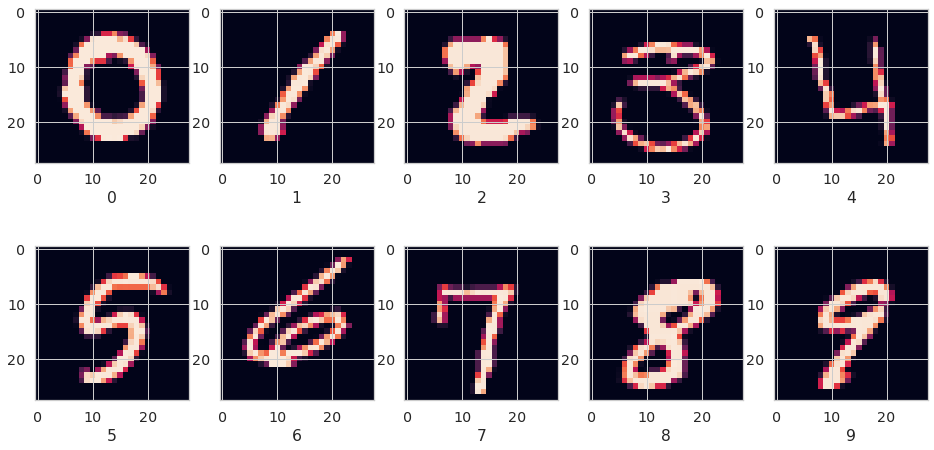

In [11]:
print_one_from_each("28_digits", digits, 28)

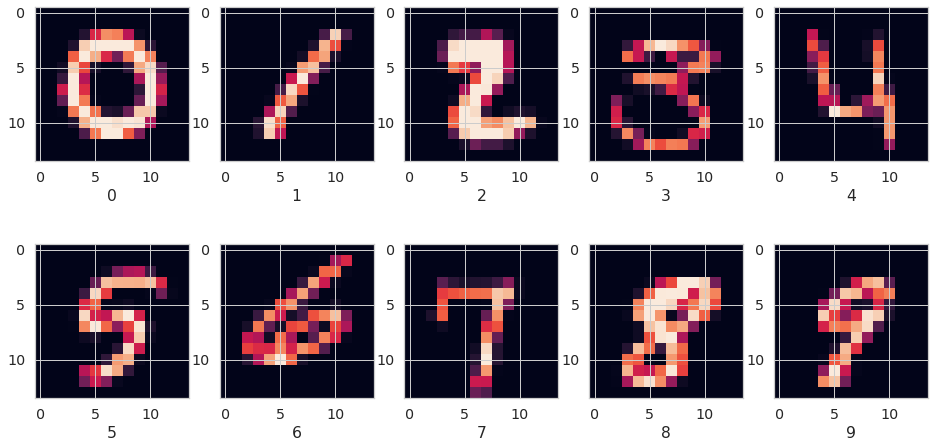

In [12]:
# visually sampling the resized data
print_one_from_each("14_digits", digitsResized, 14)

#### Drop useless features

Useless features are those with constant values across all data points, hence cannot be used to distinguish between data.

In [13]:
def filterConstantFeature(matrix, idx):
    return False if np.var(matrix[:, idx]) == 0.0 else True

cols_digits = list(range(0, len(digits[0])))
usefulCols_digits = [filterConstantFeature(digits, i) for i in cols_digits]
digitsFiltered = digits[:, usefulCols_digits]

cols_digitsResized = list(range(0, len(digitsResized[0])))
usefulCols_digitsResized = [filterConstantFeature(digitsResized, i) for i in cols_digitsResized]
digitsResizedFiltered = digitsResized[:, usefulCols_digitsResized]     
# DATA: digits -> resized to 14x14 -> dropped constant features.

# print(np.shape(digitsResized))
# print(np.shape(digitsResizedFiltered))

In [14]:
# given some restriction on later parts of the assignment,
# should we train ALL models with said restrictions for consistency's sake?
# those being only training on 5000 samples and testing on the remaining (37000) samples

# Part 1. INK Feature Models
- Model 1. (Zero mean and SD=1) Multinomial Logit -> Ink Feature
- Model 2. (Zero mean and SD=1) MN Logit -> Ink Feature + Our own special feature

In [15]:
# preparing to build both features
def print_feature(feat, feat_mean, feat_std):
    print(f"{feat}\n{feat_mean}\n{feat_std}\n")
    print(f"{np.size(feat)}, {np.size(feat_mean)}, {np.size(feat_std)}")

In [16]:
# creating ink feature
ink = np.array([sum(row) for row in digits])
print(f"Ink Feature:\n {ink}")

Ink Feature:
 [16649 44609 13425 ... 31504 26381 18178]


In [17]:
ink_mean = [np.mean(ink[labels == i]) for i in range(10)] # mean for each digit
ink_std = [np.std(ink[labels == i]) for i in range(10)] # std for each digit
print_feature(ink, ink_mean, ink_std)

[16649 44609 13425 ... 31504 26381 18178]
[34632.40755082285, 15188.466268146884, 29871.099353603066, 28320.188002757986, 24232.72249508841, 25835.920421607378, 27734.917331399563, 22931.244262667577, 30184.148412503077, 24553.75]
[8461.892043158483, 4409.461697281539, 7653.006198983366, 7574.104535679545, 6374.633457092554, 7526.602988920305, 7530.503187255003, 6168.3408781754315, 7777.396357381105, 6465.231330430596]

42000, 10, 10


In [98]:
def line_counter(array):
    counter = 0
    line_start = False
    for pixel in array:
        if line_start == False and pixel > 0 :
            line_start = True
        if line_start == True and pixel < 1:
            line_start = False
            counter += 1
    return counter

In [100]:
# our new feature - number of lines (horizontal and vertically)
# how many one-line pixels are enveloped by zero pixels
# rows and columns; 0 has a LOT of whitespace, 1 doesn´t have that much
def build_line_feature(digits, max_count=6, img_size=28):
    """
    building line counter feature
    digits: array for all digits and all pixel values
    max_count: max number of lines being counted
    img_size: size of the image (default is 28x28)
    """ 
    num_samples = len(digits)
    df_lines = pd.DataFrame(index=(range(len(digits))))
    # setting up empty dataframe
    directions = ['h', 'v']
    for direction in directions:
        for i in range(max_count):
            new_col = f"{direction}_{i}_line"
            df_lines[new_col] = 0
    
    
    for index, digit in enumerate(digits): # each digit has img_size*img_size (784) elements
        offset, x = 0, 0
        for i in range(img_size): # img_size rows and columns on each digit
            row = digit[(0+offset):(img_size+offset)]
            col_indexes = np.arange(start=x, stop=(img_size*img_size), step=img_size)
            col = np.array([digit[x] for x in col_indexes])
            # print(f"\n{row}\n{column}")
            
            h_count, v_count = line_counter(row), line_counter(col)
            df_lines.at[index, f"h_{h_count}_line"] += 1
            df_lines.at[index, f"v_{v_count}_line"] += 1
            
            offset += img_size
            x += 1
        # plt.imshow(digit.reshape(img_size, img_size))
        # plt.show()
        # break
        
    return df_lines

In [106]:
# don´t run this unless stricly necessary
start = perf_counter()
# df_lines = build_line_feature(digits)
end = perf_counter()
print(f"Took {end-start:.2f} seconds to build line counting feature.")
# lines_mean = [np.mean(lines[labels == i]) for i in range(10)] # mean for each digit
# lines_std = [np.std(lines[labels == i]) for i in range(10)] # sd for each digit
# print_feature(lines, lines_mean, lines_std)

Took 87.71 seconds to build line counting feature.


In [107]:
df_lines.describe()

,h_0_line,h_1_line,h_2_line,h_3_line,h_4_line,h_5_line,v_0_line,v_1_line,v_2_line,v_3_line,v_4_line,v_5_line
count,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000
mean,8.256738,14.447048,5.090500,0.204690,0.001000,0.000024,12.365024,7.999024,5.858357,1.746357,0.031095,0.000143
std,0.981878,4.029458,3.813827,0.737722,0.034489,0.004880,3.854687,3.602049,3.588119,2.451583,0.239317,0.013801
min,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,12.000000,2.000000,0.000000,0.000000,0.000000,9.000000,5.000000,3.000000,0.000000,0.000000,0.000000
50%,8.000000,15.000000,5.000000,0.000000,0.000000,0.000000,12.000000,8.000000,6.000000,0.000000,0.000000,0.000000
75%,8.000000,18.000000,8.000000,0.000000,0.000000,0.000000,14.000000,10.000000,8.000000,3.000000,0.000000,0.000000
max,19.000000,20.000000,19.000000,11.000000,3.000000,1.000000,26.000000,20.000000,19.000000,15.000000,7.000000,2.000000


In [120]:
# helper function to print results
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_results(filename, y_test, y_pred):
    print(f"\nResults for {filename}\n")
    print(classification_report(y_test, y_pred, zero_division=0)) # hiding zero division warn
    cm = confusion_matrix(y_test, y_pred, labels=scaled_logit.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=scaled_logit.classes_)
    disp.plot()
    plt.grid(visible=None)
    plt.show()
    # TODO: how to save this as pic?
    disp.figure_.savefig(f"{filename}.png", dpi=300)

## Model 1. MN Logit (only INK feature)

In [121]:
# pipeline setup to facilitate modelling; consolidate training and testing datasets
# https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

l1f_features = ink.reshape(-1, 1) # reshaping since it's a single feature
# I know the instructions mention we don´t need to do this now,
# but I´d rather keep all models (reasonably) consistent
l1f_train, l1f_test, y_l1f_train, y_l1f_test = train_test_split(l1f_features, labels, 
                                                    random_state=42, 
                                                    test_size=0.2)

# this pipeline logic is so we don´t leak data from the test set into the training set
scaled_logit = make_pipeline(StandardScaler(), LogisticRegression())
start_t1 = perf_counter()
scaled_logit.fit(l1f_train, y_l1f_train)  # apply scaling on training data
scaled_logit.score(l1f_test, y_l1f_test)
end_t1 = perf_counter()
print(f"Took {end_t1-start_t1:.2f} seconds to train 1st LOGIT model (ink feature)")
y_l1f_pred = scaled_logit.predict(l1f_test)

Took 0.21 seconds to train 1st LOGIT model (ink feature)



Results for mn_logit-ink_feature

              precision    recall  f1-score   support

           0       0.25      0.58      0.35       816
           1       0.43      0.84      0.57       909
           2       0.14      0.10      0.12       846
           3       0.14      0.20      0.16       937
           4       0.00      0.00      0.00       839
           5       0.00      0.00      0.00       702
           6       0.09      0.02      0.04       785
           7       0.16      0.38      0.22       893
           8       0.00      0.00      0.00       835
           9       0.16      0.08      0.11       838

    accuracy                           0.23      8400
   macro avg       0.14      0.22      0.16      8400
weighted avg       0.14      0.23      0.16      8400



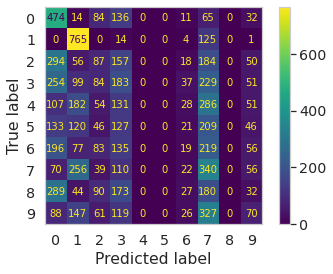

In [122]:
show_results("mn_logit-ink_feature", y_l1f_test, y_l1f_pred)

## Model 2. MN Logit (INK feature + Our Feature)

In [123]:
df_lines["ink"] = ink
l2f_features = df_lines
l2f_train, l2f_test, y_l2f_train, y_l2f_test = train_test_split(l2f_features, labels, 
                                                    random_state=42, 
                                                    test_size=0.2)

# this pipeline logic is so we don´t leak data from the test set into the training set
scaled_logit = make_pipeline(
    StandardScaler(), 
    LogisticRegression(C=0.5, max_iter=2000, penalty='l1', solver='saga')
)
start_t2 = perf_counter()
scaled_logit.fit(l2f_train, y_l2f_train)  # apply scaling on training data
scaled_logit.score(l2f_test, y_l2f_test)
end_t2 = perf_counter()
print(f"Took {end_t2-start_t2:.2f} seconds to train 2nd LOGIT model (both features)")
y_l2f_pred = scaled_logit.predict(l2f_test)

Took 106.11 seconds to train 2nd LOGIT model (both features)


/usr/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Results for MN LOGIT - BOTH FEATURES

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       816
           1       0.90      0.96      0.93       909
           2       0.42      0.41      0.42       846
           3       0.58      0.63      0.61       937
           4       0.73      0.79      0.76       839
           5       0.45      0.41      0.43       702
           6       0.46      0.33      0.38       785
           7       0.56      0.62      0.59       893
           8       0.56      0.55      0.55       835
           9       0.45      0.42      0.44       838

    accuracy                           0.61      8400
   macro avg       0.60      0.61      0.60      8400
weighted avg       0.60      0.61      0.61      8400



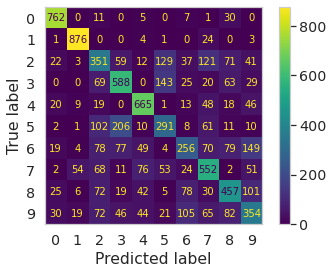

In [124]:
show_results("MN LOGIT - BOTH FEATURES", y_l2f_test, y_l2f_pred)

# Part 2. All Pixel Values Models
_**NOTE: Both with 196 (14*14 pixels) features (all resized pixel values)**_

- Model 3. (Regularized?) MN Logit (w/ LASSO penalty) 
- Model 4. Support Vector Machines (SVM)

In [129]:
# separating training and test samples
p2_features = digitsResized
p2_train, p2_test, y_p2_train, y_p2_test = train_test_split(p2_features, labels, 
                                                    random_state=42, 
                                                    test_size=0.6)

### MN Logit (w/ LASSO penalty)

In [130]:
from sklearn.linear_model import LogisticRegression

# saga is the only solver that supports l1 penalty and multi-class problems
# arr = np.array([ink_mean, ink_std])
# print(pd.DataFrame(arr))
# print(df.loc[:, (df.sum() > 0).all()])

p2_logit = make_pipeline(
    StandardScaler(), 
    LogisticRegression(C=0.5, max_iter=1000, penalty='l1', solver='saga')
)

start_p2m1 = perf_counter()
p2_logit.fit(p2_train, y_p2_train)
p2_logit.score(p2_test, y_p2_test)
end_p2m1 = perf_counter()
print(f"Took {end_p2m1-start_p2m1:.2f} seconds to train LOGIT model (all pixel values)")
p2_logit_pred = p2_logit.predict(p2_test)

Took 235.71 seconds to train LOGIT model (all pixel values)


/usr/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Results for MN LOGIT - ALL PIXEL VALUES (14x14)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2468
           1       0.95      0.97      0.96      2797
           2       0.92      0.90      0.91      2527
           3       0.89      0.88      0.89      2634
           4       0.92      0.92      0.92      2485
           5       0.87      0.87      0.87      2233
           6       0.94      0.95      0.95      2489
           7       0.93      0.93      0.93      2647
           8       0.90      0.88      0.89      2428
           9       0.89      0.89      0.89      2492

    accuracy                           0.92     25200
   macro avg       0.92      0.92      0.92     25200
weighted avg       0.92      0.92      0.92     25200



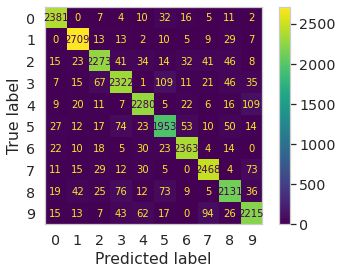

In [131]:
show_results("MN LOGIT - ALL PIXEL VALUES (14x14)", y_p2_test, p2_logit_pred)

### SVM + Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from tqdm import tqdm

# === Note on kernels and params ===
# rbf: gamma
# linear: x, x'
# sigmoid: coef0
# poly: degree, coef0
#   but coef0 can be safely left unchanged "in most cases" according to 
# https://stackoverflow.com/questions/21390570/scikit-learn-svc-coef0-parameter-range

paramGrid = {
    'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
    'C': [0.1, 0.5, 0.9, 1.5, 2, 2.5],
    'degree': [0.5, 1, 2, 5],
    'gamma': ['auto', 'scale'],
}

grid = GridSearchCV(SVC(), paramGrid, refit=True, verbose=3)
grid.fit(X_train2_std, y_train2)